# Optimization for Machine Learning 
*(P2 : Automatic Differentiation)*

In [4]:
import numpy as np

In [19]:
## We assume knowing dot function with its VJP
def dot(W, x):
    value = np.dot(W, x)

    def vjp(u):
        return np.outer(u, x), W.T.dot(u)

    return value, vjp

## ReLU Function implementation

In [20]:
def relu(x):
    """
    Calcule la partie positive du vecteur
    On utilise une formule alternative pour calculer la partie positive
    afin d'etre coherent avec la structure vectorielle

    Input :
      x : array

    Output :
      value : same dimension as x
        ReLU(x)
      
      vjp : function goes from (shape(x)) to (shape(x))
        u * grad(ReLU)(x) (with * element-wise product)
    """
    value = (x + np.abs(x))/2

    def vjp(u):
      grad = np.where(value > 0, 1, 0)
      vjp_wrt_x = u * grad
      return vjp_wrt_x

    return value, vjp

In [21]:
a, vjp = relu(np.array([1,2,3,4,-1,-2,-4]))
print(a)
print(vjp(np.array([5,6,8,0,1,1,0])))

[1. 2. 3. 4. 0. 0. 0.]
[5 6 8 0 0 0 0]


## 2-layer MLP with ReLU activation

In [22]:
def mlp2(x, W1, W2):
    """
    La fonction mlp2 est un Perceptron à deux couches avec ReLU comme 
    fonction d'activation

    Input :
      x : array 
      W1 : matrix
      W2 : matrix
    """
    value1, vjp1 = dot(W1, x)
    valuer, vjpr = relu(value1)
    value2, vjp2 = dot(W2, valuer)
    value,  out  = relu(value2)

    def vjp(u):
      vjp_wrt_W2, interm = vjp2(out(u))
      vjp_wrt_W1, vjp_wrt_x = vjp1(vjpr(interm))
      return vjp_wrt_x, vjp_wrt_W1, vjp_wrt_W2
    
    return value, vjp

In [23]:
x = np.array([1,2])

W1 = np.array([[1,2],[3,4]])
W2 = np.array([[1,1],[2,1]])
val, vjp_mlp2 = mlp2(x,W1,W2)

In [24]:
vjp_mlp2(np.array([1.,1.]))

(array([ 9., 14.]),
 array([[3., 6.],
        [2., 4.]]),
 array([[ 5., 11.],
        [ 5., 11.]]))

## Squared loss
Pour calculer le VJP de la perte carrée, il faut se souvenir que 
$$sql(y_p, y) = \frac{1}{2} ||y_p - y||^2_2$$
soit
$$sql(y_p, y) = \frac{1}{2} (y_p - y)^T(y_p - y)$$
et que donc 
$$\frac{\partial sql}{\partial y_p} = y_p - y$$
et 
$$\frac{\partial sql}{\partial y} = y - y_p$$

In [25]:
def squared_loss(y_pred, y):
    residual = y_pred - y
    
    def vjp(u):
        vjp_y_pred = u * residual
        vjp_y      = -u * residual
        return vjp_y_pred, vjp_y

    value = 0.5 * np.sum(residual ** 2)
    # The code requires every output to be an array.
    return np.array([value]), vjp

In [26]:
test_y_pred = np.array([1.,1.,1.])
test_y      = np.array([0.9,1.1,1.])
result, vjp_sl = squared_loss(test_y_pred, test_y)

In [27]:
print(result)
print(vjp_sl(np.array([1.,1.,1.])))

[0.01]
(array([ 0.1, -0.1,  0. ]), array([-0.1,  0.1, -0. ]))


## Fonction de loss

In [28]:
def loss(x, y, W1, W2):
    y_mlped, vjp2 = mlp2(x, W1, W2)
    value, vjpt = squared_loss(y_mlped, y)
    
    def vjp(u):
      interm, vjp_wrt_y= vjpt(u)
      vjp_wrt_x, vjp_wrt_W1, vjp_wrt_W2 = vjp2(interm)
      return vjp_wrt_x, vjp_wrt_y, vjp_wrt_W1, vjp_wrt_W2

    return value, vjp

In [29]:
x = np.array([1,2])
y = np.array([15,21])
W1 = np.array([[1,2],[3,4]])
W2 = np.array([[1,1],[2,1]])

In [30]:
val, vjp = loss(x,y,W1,W2)
print(val)
print(vjp(np.array([1.,1.])))

[0.5]
(array([4., 6.]), array([-1., -0.]), array([[1., 2.],
       [1., 2.]]), array([[ 5., 11.],
       [ 0.,  0.]]))


## MLP avec un nombre arbitraire de couches

In [47]:
def mlpn(x, *W):
    n = len(W)
    vjplist = []
    vjrlist = []
    currentstep = np.array(x)
    for i in range(n-1):
      currentstep, vjp = dot(W[i], currentstep)
      currentstep, vjr = relu(currentstep)
      vjplist.append(vjp)
      vjrlist.append(vjr)
    currentstep, vjp = dot(W[n-1], currentstep)
    vjplist.append(vjp)
    value = currentstep[:]
    
    def vjp(u):
      vjp_wrt = []
      tmp = u[:]
      v, tmp = vjplist[n-1](tmp)
      vjp_wrt.append(v[:])
      for i in range(1,n):
        v, tmp = vjplist[n-i-1](vjrlist[n-i-1](tmp))
        vjp_wrt.append(v[:])
      vjp_wrt.append(tmp * x)
      return vjp_wrt[::-1]
    
    return value, vjp

In [48]:
x = np.array([1,2])

W1 = np.array([[1,2],[3,4]])
W2 = np.array([[1,1],[2,1]])
W = [W1, W2]
val, vjp_mlpn = mlpn(x,*W)

print(vjp_mlpn(np.array([1.,1.])))

val, vjp_mlpn = mlpn(x,W1,W2)

print(vjp_mlpn(np.array([1.,1.])))

[array([ 9., 28.]), array([[3., 6.],
       [2., 4.]]), array([[ 5., 11.],
       [ 5., 11.]])]
[array([ 9., 28.]), array([[3., 6.],
       [2., 4.]]), array([[ 5., 11.],
       [ 5., 11.]])]


In [49]:
def loss(x, y, *W):
    y_mlped, vjpn = mlpn(x, *W)
    value, vjpt = squared_loss(y_mlped, y)
    
    def vjp(u):
      interm, vjp_wrt_y= vjpt(u)
      vjp_wrt_all = vjpn(interm)
      return vjp_wrt_all[0], vjp_wrt_y, vjp_wrt_all[1:]

    return value, vjp

In [51]:
x = np.array([1,2])
y = np.array([15,21])
W1 = np.array([[1,2],[3,4]])
W2 = np.array([[1,1],[2,1]])

val, vjp = loss(x,y,W1,W2)
print(val)
print(vjp(np.array([1.,1.])))

[0.5]
(array([ 4., 12.]), array([-1., -0.]), [array([[1., 2.],
       [1., 2.]]), array([[ 5., 11.],
       [ 0.,  0.]])])


In [54]:
x = np.array([1,2])
y = np.array([16,22])
W1 = np.array([[1,2],[3,4]])
W2 = np.array([[1,1],[2,1]])

print(mlpn(x,W1,W2))
val, vjp = loss(x,y,W1,W2)
print(val)
print(vjp(np.array([1.,1.])))

(array([16., 21.]), <function mlpn.<locals>.vjp at 0x0000017902A61D80>)
[0.5]
(array([ -5., -16.]), array([-0.,  1.]), [array([[-2., -4.],
       [-1., -2.]]), array([[  0.,   0.],
       [ -5., -11.]])])




---


## SGD pour entraîner un MLP





### Chargement du dataset

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

#  convert to a column vector
def MakeCol(y): return y.reshape(-1,1)
#  convert to a row vector
def MakeRow(y): return y.reshape(1,-1)
# find non zero/true elements
def find(x): return np.nonzero(x)[0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Use this code to read from a CSV file.
import pandas as pd
U = pd.read_csv('data/space_ga.csv', delimiter=';')

In [62]:
class_names = list(U.columns)
Ay = U.to_numpy()

In [63]:
# Shuffle
Ay = Ay[np.random.permutation(Ay.shape[0]),:]
# Separation features X / donnees y
A_full = Ay[:,1:];
y_full = MakeCol( Ay[:,0] )

In [64]:
n_train = 2170
n_test = 937
A_train = A_full[:n_train, :]
A_test = A_full[n_train:,:]
y_train = y_full[:n_train,:]
y_test = y_full[n_train:,:]

A, A1, y, y1 = A_train, A_test, y_train, y_test

In [65]:
# Centrer données
mA = A.mean(axis=0)
sA = A.std(axis=0)
A = (A-mA)/sA
A1 = (A1-mA)/sA

m = y.mean()
y = y-m
y1 = y1-m

### Construction du MLP

In [66]:
print(np.shape(A), np.shape(y))

(2170, 6) (2170, 1)


In [67]:
Wd1 = np.random.rand(6,10)
Wd2 = np.random.rand(10,3)
Wd3 = np.random.rand(3,1)

In [68]:
y

array([[0.00406185],
       [0.06077063],
       [0.08649452],
       ...,
       [0.2281337 ],
       [0.32529982],
       [0.21623256]])

In [123]:
def sgd_study(At, yt, dpth, wdth):
    print(np.shape(At), np.shape(yt))
    iternb = 100000
    score = [0 for _ in range(iternb)]
    W = []
    if dpth <= 0:
        W0 = np.random.rand(1,6)
        W.append(W0)
    else:
        W0 = np.random.rand(wdth,6)
        W.append(np.array(W0))
        for i in range(0,wdth-1):
            W.append(np.random.rand(wdth,wdth))
        W.append(np.random.rand(1,wdth))
    for i in range(iternb):
        alpha = 1/((i//1000+1)+1)
        k = np.random.randint(2170)
        xk = At[k,:]
        yk = yt[k]
        v, vjp = loss(xk, yk, *W)
        score[i] = v[0]
        vjp_x, vjp_y, vjp_w = vjp(np.array([1.]))
        for j in range(len(W)):
            W[j] = W[j] - alpha * vjp_w[j]
    return score

In [124]:
score_0_1 = sgd_study(A, y, 0, 1)
score_1_10 = sgd_study(A, y, 1, 10)
score_2_10 = sgd_study(A, y, 2, 10)

(2170, 6) (2170, 1)
(2170, 6) (2170, 1)
(2170, 6) (2170, 1)


In [128]:
score_0_1

[0.068954617567532,
 0.45877471648058316,
 0.03263199787458575,
 0.015711661741090847,
 0.01957721637425737,
 0.7290294431996209,
 1.0495818570473143,
 0.0034675414796594872,
 0.027569941374147006,
 0.5151461591880758,
 0.0069074057875915485,
 0.016081061331002136,
 0.012662870722808453,
 0.06225513097156825,
 0.05000190070310366,
 0.15712791591967762,
 0.014833599402106594,
 0.0002641069343186859,
 0.008647084352953463,
 0.03694295047543787,
 0.008393175050830457,
 0.0028522906312265263,
 0.2195387802774998,
 0.019535361742167284,
 1.810477659999947,
 1.7062322416293878,
 0.8900745359946088,
 0.00973078834106822,
 0.29130281136440067,
 22.32930946628173,
 24.58033522899139,
 815.4318245183041,
 678.5044206961783,
 1030.9915807098243,
 1274.6489501236688,
 14209.75280773018,
 24528.462124499594,
 18118.64008999232,
 22.49311827528877,
 4377.5807350582945,
 3238.281478354899,
 2172.3154248109836,
 5838.667710993159,
 9105.450781755615,
 99462.37702395135,
 5296539.034908284,
 77903683.3

In [130]:
score_3_10 = sgd_study(A, y, 3, 10)
score_4_10 = sgd_study(A, y, 4, 10)
score_5_10 = sgd_study(A, y, 5, 10)

(2170, 6) (2170, 1)
(2170, 6) (2170, 1)
(2170, 6) (2170, 1)


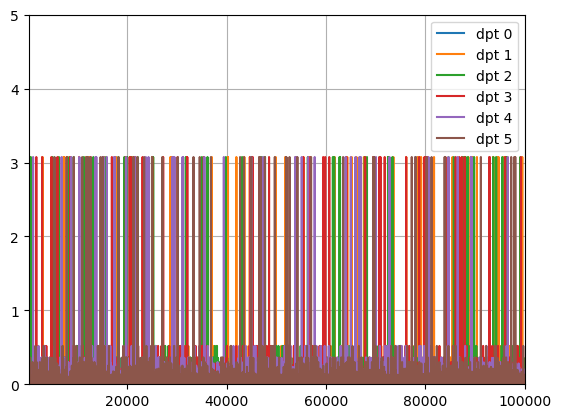

In [132]:
plt.plot(score_0_1[100:], label='dpt 0')
plt.plot(score_1_10[100:], label='dpt 1')
plt.plot(score_2_10[100:], label='dpt 2')
plt.plot(score_3_10[100:], label='dpt 3')
plt.plot(score_4_10[100:], label='dpt 4')
plt.plot(score_5_10[100:], label='dpt 5')
plt.axis([100,100000,0,5])
plt.legend()
plt.grid()
plt.show()

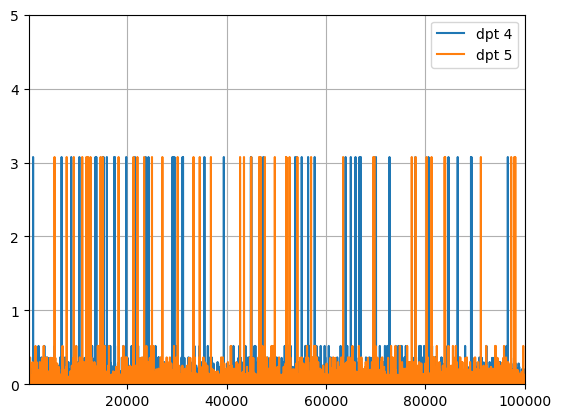

In [133]:

plt.plot(score_4_10[100:], label='dpt 4')
plt.plot(score_5_10[100:], label='dpt 5')
plt.axis([100,100000,0,5])
plt.legend()
plt.grid()
plt.show()

In [118]:
score_1_1 = sgd_study(A, y, 1, 1)
score_1_5 = sgd_stu2dy(A, y, 1, 5)
score_1_10 = sgd_study(A, y, 1, 10)
score_1_15 = sgd_study(A, y, 1, 15)

(2170, 6) (2170, 1)


C:\Users\ridal\AppData\Local\Temp\ipykernel_60508\3725364859.py:9: RuntimeWarning: overflow encountered in square
  value = 0.5 * np.sum(residual ** 2)
C:\Users\ridal\anaconda3\envs\deepl\lib\site-packages\numpy\core\numeric.py:942: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


(2170, 6) (2170, 1)
(2170, 6) (2170, 1)
(2170, 6) (2170, 1)


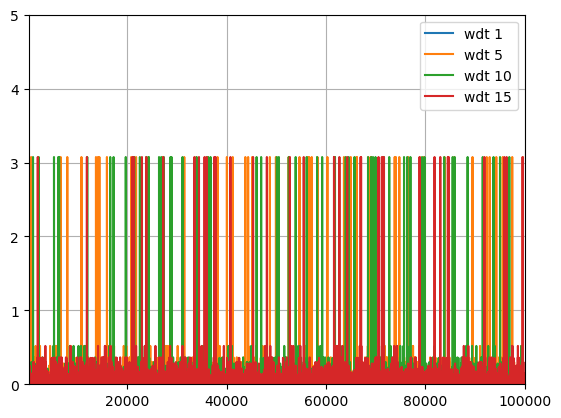

In [119]:
plt.plot(score_1_1[100:], label='wdt 1')
plt.plot(score_1_5[100:], label='wdt 5')
plt.plot(score_1_10[100:], label='wdt 10')
plt.plot(score_1_15[100:], label='wdt 15')
plt.axis([100,100000,0,5])
plt.legend()
plt.grid()
plt.show()